<h1> <strong> Titanic Competition Kaggle </strong> </h1>
<hr>

This is the notebook to develop the competition related to <a href = "https://www.kaggle.com/competitions/titanic/data">Titanic</a> competiton. First I load the libraries requered to implemented.

<h2> <strong> Libraries </strong> </strong> </h2>
<hr>

The next are the libraries implemented to the challenge:
<ul>
<li> pandas 
<li> os
<li> numpy
<li> ptitprince
<li> matplotlib.pyplot
</ul>

In [61]:
import pandas as pd
import os
import numpy as np
import ptitprince as pt
import matplotlib.pyplot as plt
import seaborn as sns

<h2> <strong> Databases </strong> </h2>
<hr>

Now we must load the data to work. In this case we have two databases:
<ul>
<li> test.csv with this, we prove the models implemented.
<li> train.csv has all of the registers to train the models that i want to use.
</ul>

In [62]:
# os.chdir(path=os.getcwd() + "\\Titanic_Competition_Kaggle")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

<h2> <strong> Exploratory Analysis </h2> </strong>
<hr>

After load the databases, I do a exploratory analysis. Also we modify the variables acording they nature.

In [63]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

With the last code, we can identify the types of each column, and with this, change to the correct type.

In [64]:
test = test.astype({"PassengerId":str, "Sex": "category", "Pclass":"category", "Embarked": "category"})
train = train.astype({"PassengerId":str, "Sex": "category", "Pclass":"category", "Embarked": "category", "Survived": "category"})

Now we calculate a metrics to see the comportament of the data:

In [65]:
train.describe(include='all').fillna(0)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891.0,891.0,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,891,2.0,3.0,891,2,0.000000,0.000000,0.000000,681,0.000000,147,3
top,1,0.0,3.0,"Braund, Mr. Owen Harris",male,0.000000,0.000000,0.000000,347082,0.000000,B96 B98,S
freq,1,549.0,491.0,1,577,0.000000,0.000000,0.000000,7,0.000000,4,644
mean,0,0.0,0.0,0,0,29.699118,0.523008,0.381594,0,32.204208,0,0
std,0,0.0,0.0,0,0,14.526497,1.102743,0.806057,0,49.693429,0,0
min,0,0.0,0.0,0,0,0.420000,0.000000,0.000000,0,0.000000,0,0
25%,0,0.0,0.0,0,0,20.125000,0.000000,0.000000,0,7.910400,0,0
50%,0,0.0,0.0,0,0,28.000000,0.000000,0.000000,0,14.454200,0,0
75%,0,0.0,0.0,0,0,38.000000,1.000000,0.000000,0,31.000000,0,0


This table is not many informative, for this, we want to see the result using variables to group the data.

In [66]:
def descriptive_cross(var, dataframe = train):
    """This function calculate the mean of the quantitative variables
    given a categorical(s) variable(s). This is only for this project
    
    var: This can be a string given the name of the variable or a list of
    categorical variables
    
    dataframe: This is the dataframe that we are used for train"""

    result = (
        dataframe.
        groupby(var, observed=True).
        agg(
            PassengerId = ("PassengerId", "size"),
            Age = ("Age", lambda x: np.round(np.mean(x), 2)),
            SibSp = ("SibSp", lambda x: np.round(np.mean(x),2)),
            Parch = ("Parch", lambda x: np.round(np.mean(x),2)),
            Fare = ("Fare", lambda x: np.round(np.mean(x),2))
    ).
    reset_index()
    )

    return result

Now, for example, if we want to see the comparative with sex, survival, o Pclass, we can use this:

In [69]:
descriptive_cross(var = ["Survived","Sex", "Pclass"])

,Survived,Sex,Pclass,PassengerId,Age,SibSp,Parch,Fare
0,0,female,1,3,25.67,0.67,1.33,110.60
1,0,female,2,6,36.00,0.50,0.17,18.25
2,0,female,3,72,23.82,1.29,1.10,19.77
3,0,male,1,77,44.58,0.27,0.26,62.89
4,0,male,2,91,33.37,0.31,0.14,19.49
5,0,male,3,300,27.26,0.52,0.21,12.20
6,1,female,1,91,34.94,0.55,0.43,105.98
7,1,female,2,70,28.08,0.49,0.64,22.29
8,1,female,3,72,19.33,0.50,0.50,12.46
9,1,male,1,45,36.25,0.38,0.31,74.64


We found that the female people survived more than male, and dead more male that female, also, the Fare of the female that survived was the highest mean to the others groups. Finally, the female group that had Pclass equals to 1 and survived, was the group with more integers.

<h3> <strong> Sex Variable Analysis </h3> </strong>
<hr>

Now we analyze the <i> Sex </i> variable, cross first with the numerical variables, and then with the categorical.

c:\Users\dags0\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\dags0\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\dags0\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain

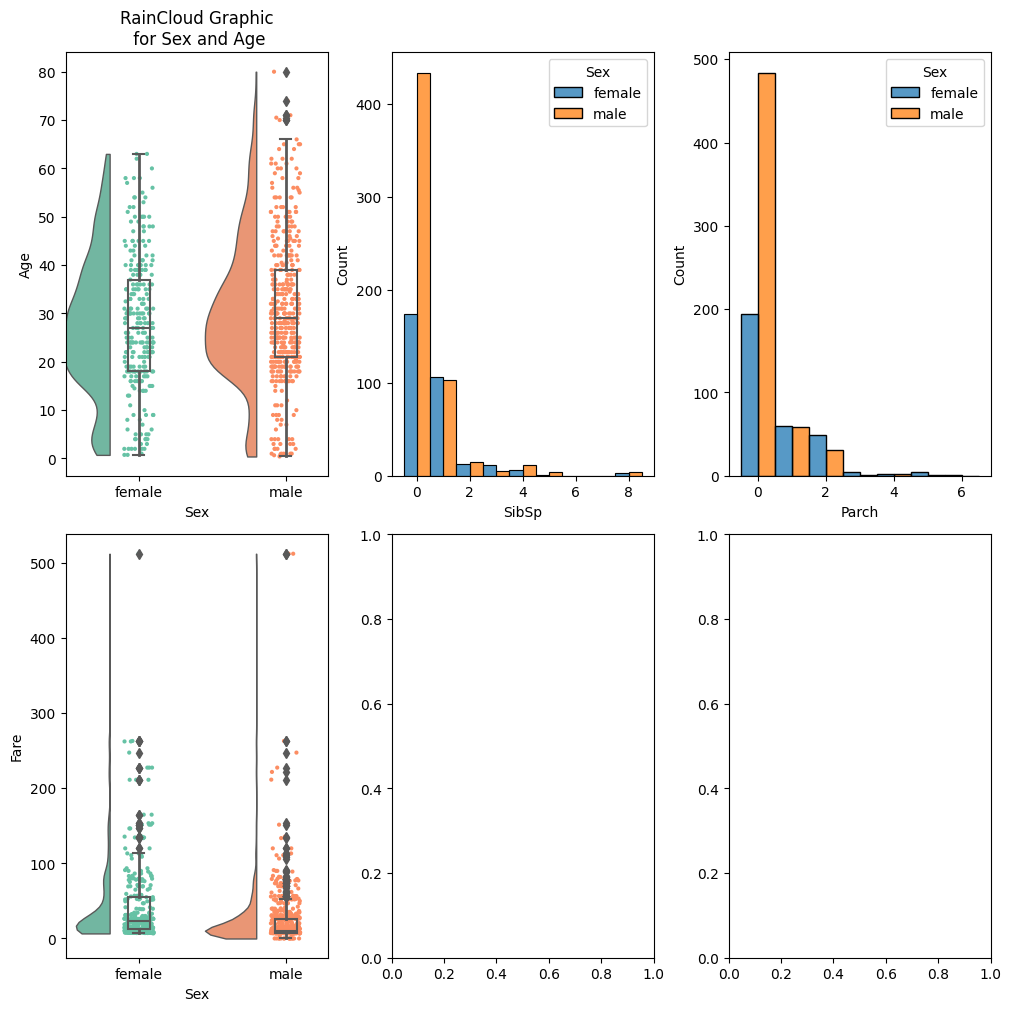

In [77]:
fig = plt.figure(layout="constrained", figsize=(10, 10))
ax_dict = fig.subplot_mosaic([
    ["A","B", "C"],
    ["D", "E", "F"]])

pt.RainCloud(
    data=train,
    x = "Sex",
    y = "Age",
    ax = ax_dict['A']
)

sns.histplot(
    data=train,
    x = "SibSp",
    hue="Sex",
    multiple = "dodge",
    discrete=True,
    ax=ax_dict["B"]
)

sns.histplot(
    data=train,
    x = "Parch",
    hue="Sex",
    multiple = "dodge",
    discrete=True,
    ax=ax_dict["C"]
)

pt.RainCloud(
    data=train,
    x = "Sex",
    y = "Fare",
    ax = ax_dict['D']
)

ax_dict['A'].set_title("RainCloud Graphic\n for Sex and Age")
plt.show()